# **Project 4:** Policy Impacts on Ethiopia's Household Nutritional Adequacy and Food Demand Systems
**Group:** Luther Tweeten  
**Authors:** Colby Alonzo, Dahalan Vijayakumar, Fari Santoso, Ziheng Zhang, Noah Mujica
## 📖 Table of Contents
1. [Introduction & Imports](#introduction--imports)  
2. [Ethiopia Household Data](#Ethiopia-Household-Data)  
   - **Deliverable 1[A]** - Ethiopia 2018-2019 Household Data Collection
        - Household Characteristic Data Frame ($d$)
        - Log Expenditure Data Frame ($y$)
        - Regression Model
3. [Demand Systems](#Demand-Systems)
    - **Deliverable 2[A]** - Estimating Demand Systems
        - FCT Dataframe
        - RDI Dataframe
        - Reference Prices
        - Budgets
        - Food Quantities
        - Demand Systems for Specific Goods
        - Engel Curves of Etiopian Households in 2018-2019
4. [Nutrient System](#Nutrient-System)  
   - **Deliverable 3[A]** - Constructing Nutrient System
        - Nutrient Intake Responses to Changes in Household Food Budget (Log Scale)
        - Price Elasticity of Nutrient Intake for Specific Foods
        - Nutritional Adequcy for Households
        - Log Nutrient Adequacy Ratios vs. Household Budget
        - Nutrient Adequacy Sensitivity to Price Changes (Good-Specific)
5. **Basic Visualizations:** Hicksian & Marshallion Demand, Welfare Measures, Deadweight Loss
   - Marshallion vs. Hicksian Demand Curves  
   - **Welfare Measures:** Price Changes, Revenue, and Compensating Variation 
   - Deadweight Loss
6. [Policy Approaches](#Policy-Approaches)    
    - **Deliverable 4[A]** - **Policy 1:** Cash Transfer and Nutritional Systems
    - **Deliverable 4[A]** - **Policy 2:** Forestry Development
    - **Deliverable 4[A]** - **Policy 3:** Biofortification
7. [Additional Visualizations](#Additional-Visualizations)  
    - Price of Goods on Avg (Bar Grapu
---


## **Introduction & Imports**

In [39]:
%pip install -r requirements.txt
import pandas as pd
import cfe.regression as rgsn
import numpy as np
from eep153_tools.sheets import read_sheets
import matplotlib.pyplot as plt
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


# **Ethiopia Household Data**
## **Deliverable 1[A]** - Ethiopia 2018-2019 Household Data Collection

In [40]:
# Name Ethiopia google sheet API key Ethiopia_Data
Ethiopia_Data = '148rioTUyUTcgjbZCqobeXiufm0gG4evxeWXD-Hr_OiA'
expenditures = read_sheets(Ethiopia_Data,sheet='Food Expenditures (2018-19)')
prices = read_sheets(Ethiopia_Data,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

In [41]:
# Read Food Expenditures (2018-19) sheet from 'Ethiopia_Data' key 
x = read_sheets(Ethiopia_Data,sheet='Food Expenditures (2018-19)')
x = x.set_index(['i','t','m','j']).squeeze()

# Same step for prices
p = read_sheets(Ethiopia_Data,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Get intersection of goods that we have prices *and* expenditures for:
jidx = p.columns.intersection(x.index.levels[-1])

# Drop prices for goods we don't have expenditures for
p = p[jidx].T

# Read sheet for household characteristics
d = read_sheets(Ethiopia_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

# Reset indexes of household characteristic data frame
d.set_index(['i','t','m'],inplace=True)

### Household Characteristics Dataframe ($d$)

In [42]:
d.head()

k                             Females 00-03  Females 04-08  Females 09-13  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              1              1              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              1              1   
              2013-14 Tigray              1              1              1   

k                             Females 14-18  Females 19-30  Females 31-50  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              0              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              1              0   

k                             Females 51-99  Males 00-03  Males 04-08  \
i             t       m                                                 
1010101601002 2011-12 Tigray              1            0            1   
              2013-14 Tigray              1            0            1   
              2015-16 Tigray              1            0            0   
1010101601017 2011-12 Tigray              0            0            0   
              2013-14 Tigray              0            0            1   

k                             Males 09-13  Males 14-18  Males 19-30  \
i             t       m                                               
1010101601002 2011-12 Tigray            1            1            0   
              2013-14 Tigray            0            1            0   
              2015-16 Tigray            0            0            0   
1010101601017 2011-12 Tigray            2            0            0   
              2013-14 Tigray            1            1            0   

k                             Males 31-50  Males 51-99  log HSize  
i             t       m                                            
1010101601002 2011-12 Tigray            1            0   1.945910  
              2013-14 Tigray            1            0   2.079442  
              2015-16 Tigray            0            0   0.000000  
1010101601017 2011-12 Tigray            1            0   1.791759  
              2013-14 Tigray            1            0   2.079442

### Log Expenditure Dataframe ($y$) 
Note that any expenditures of zero are dropped and replaced with a missing value indicator.

In [43]:
y.head()

i                   t        m       j     
010101088800910007  2018-19  Tigray  Coffee    3.401197
                                     Onion     2.197225
                                     Salt      1.098612
                                     Shiro     2.484907
                                     Sugar     2.484907
Name: Expenditure, dtype: float64

### Regression Model 
Run using $y$ and $d$ dataframes as predictors.

In [44]:
# Name output of regression model r
r = rgsn.Regression(y=y,d=d)

# Predicted expenditures through regression model
r.predicted_expenditures()

i                   t        m       j       
010101088800910017  2018-19  Tigray  Banana       13.722784
                                     Barley       25.973461
                                     Beef        163.760280
                                     Beetroot     10.094725
                                     Berbere      18.426590
                                                    ...    
7.10031E+16         2018-19  SNNP    Sugar         8.228985
                                     Tea           6.651267
                                     Teff         66.335750
                                     Tomato        7.975301
                                     Wheat        22.549419
Length: 191958, dtype: float64

# **Demand Systems**

Using the data on household characteristics and (log) expenditures, we can estimate the demand system (`d`,`y`).  This gives us predictions of expenditures on different kinds of foods.  Then if we divide these expenditures by prices, we get predicted quantities of food.

However, here we&rsquo;re interested in nutritional outcomes, so we need a food conversion table:

## **Deliverable 2[A]** - Estimating Demand Systems
### FCT Dataframe

In [45]:
# Load the Food Composition Table (FCT) from the specified Google Sheet
fct = read_sheets(Ethiopia_Data, sheet='FCT')

# Set the index of the DataFrame to the food item column 'j' (i.e., rows become food names)
fct = fct.set_index('j')

# Rename the column axis to 'n', representing nutrient names (e.g., 'Protein', 'Iron', etc.)
fct.columns.name = 'n'

# Convert all entries in the DataFrame to numeric values
# Any values that can't be converted (e.g., text) will be replaced with NaN (missing)
fct = fct.apply(lambda x: pd.to_numeric(x, errors='coerce'))

### RDI Dataframe
We also want to establish when nutrition is *adequate* for households with different compositions.  For this, we want data on recommended dietary intakes:

In [46]:
# Load the Recommended Dietary Intake (RDI) data from the specified Google Sheet
rdi = read_sheets(Ethiopia_Data, sheet='RDI')

# Set the index of the DataFrame to the nutrient name column 'n'
# Each row now corresponds to a nutrient (e.g., 'Protein', 'Calcium')
rdi = rdi.set_index('n')

# Rename the column axis to 'k', which likely represents demographic groups
# (e.g., 'Males 19–30', 'Females 04–08', etc.)
rdi.columns.name = 'k'

# Convert all entries in the DataFrame to numeric values
# Any non-numeric entries will be coerced to NaN (missing)
rdi = rdi.apply(lambda x: pd.to_numeric(x, errors='coerce'))

### Reference Prices

Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.


In [47]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.loc[r.beta.index].mean(axis=1).fillna(1) # Only use prices for goods we can estimate

### Budgets

Get food budget for all households, then find median budget:

In [48]:
# Retrieve predicted expenditures from regression and name as 'xhat'
xhat = r.predicted_expenditures()

# Total food expenditures per household per week
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget per household per week 
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median
print(xref)

1781.471524826373


### Food Quantities

Get quantities of food by dividing expenditures by prices:

In [49]:
# Get quantities of food by dividing expendtures by prices
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

Define a function to change a single price in the vector $p$:

In [50]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demand Systems for Specific Goods

In [51]:
def plot_demand_by_expenditure(good):
    """
    Plots demand curves for a given good at different household expenditure levels
    (25th, 50th, and 75th percentile) as price changes.

    Parameters:
    good (str): The name of the good for which to plot demand.
    """

    # Define a range of price multipliers (from 0.5x to 2x the base price)
    scale = np.linspace(0.5, 2, 20)

    # Plot demand curve for the household with median (50th percentile) total food budget
    plt.plot(
        [r.demands(xref, my_prices(good, pbar[good] * s, pbar))[good] for s in scale],
        scale,
        label='Median Budget'
    )

    # Plot demand curve for household at 25th percentile of total food budget
    plt.plot(
        [r.demands(xbar.quantile(0.25), my_prices(good, pbar[good] * s, pbar))[good] for s in scale],
        scale,
        label='25th Percentile Budget'
    )

    # Plot demand curve for household at 75th percentile of total food budget
    plt.plot(
        [r.demands(xbar.quantile(0.75), my_prices(good, pbar[good] * s, pbar))[good] for s in scale],
        scale,
        label='75th Percentile Budget'
    )

    # Label axes and format plot
    plt.ylabel(f"Price (relative to base of {pbar[good]:.2f})")  # Y-axis: scaled prices
    plt.xlabel(f"Quantities of {good} Demanded")                # X-axis: predicted quantity demanded
    plt.title(f"Demand for {good} at Varying Budet Percentiles")     # Plot title
    plt.legend()                                                # Add legend for each budget level
    plt.show()                                                  # Display the plot

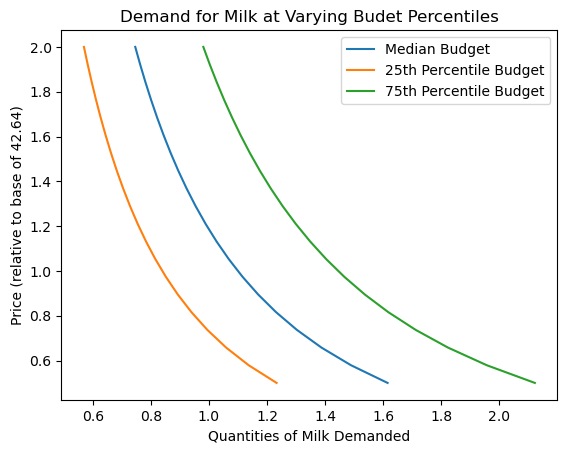

In [52]:
plot_demand_by_expenditure('Milk')

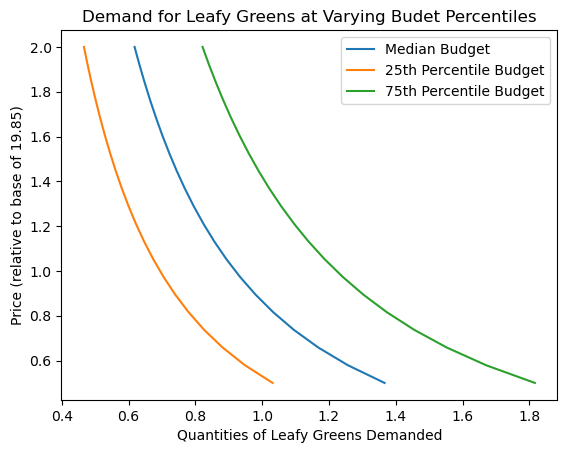

In [53]:
plot_demand_by_expenditure('Leafy Greens')

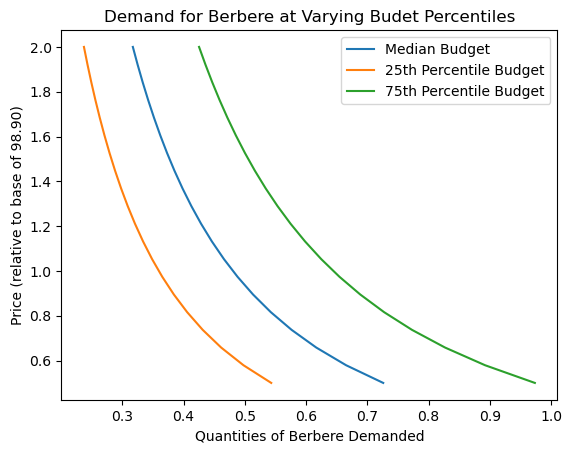

In [54]:
plot_demand_by_expenditure('Berbere')

### Engel Curves of Etiopian Households in 2018-2019

Text(0.5, 1.0, 'Engel Curves of Ethiopian Households in 2018-2019')

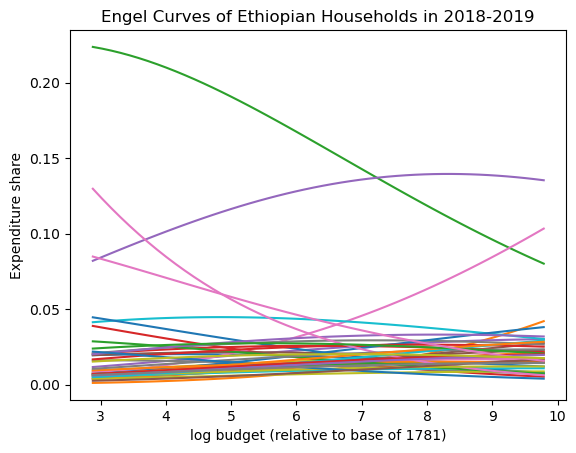

In [55]:
# Create a figure and axes object for plotting
fig, ax = plt.subplots()

# Generate a range of budget scaling factors (log-spaced from 0.01 to 10)
# This simulates households from very poor to very rich (relative to xref)
scale = np.geomspace(0.01, 10, 50)

# Plot Engel curves: for each budget level, compute total expenditures across goods,
# divide by budget to get share (i.e., budget allocation), and plot against log budget
ax.plot(
    np.log(scale * xref),  # X-axis: log of scaled budgets
    [r.expenditures(s * xref, pbar) / (s * xref) for s in scale]  # Y-axis: expenditure share (scalar)
)

# Label the x-axis as log budget (referenced to the median budget xref)
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')

# Label the y-axis as expenditure share (i.e., % of budget allocated to all goods)
ax.set_ylabel('Expenditure share')

# Set the title of the plot
ax.set_title('Engel Curves of Ethiopian Households in 2018-2019')

# **Nutrient System**
## **Deliverable 3[A]** - Constructing Nutrient System
### Mapping to Nutrients

We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:

In [56]:
fct.head()

n,Energy,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B-6,Vitamin B-12,Calcium,Magnesium,...,Zinc,Fiber,Folate,Carbohydrate,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin K
j,,,,,,,,,,,,,,,,,,,,,
Avocado,1601.338432,20.0,70,0,20.7,100,2.57,0,120.0,290.0,...,6.4,67.0,810.0,85.3,17.38,520.0,4850.0,1.3,0.67,210.0
Banana,890.000000,11.0,30,0,1.0,87,4.00,0,50.0,270.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Barley,3490.000000,123.0,0,0,10.0,0,2.00,0,260.0,920.0,...,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beef,3230.000000,249.0,0,0,0.0,0,3.00,19,40.0,230.0,...,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beer,410.000000,3.0,0,0,0.0,0,1.00,0,50.0,60.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:

In [57]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')

Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:

In [58]:
# The @ operator means matrix multiply
N = fct0.T@c0

N.head()  #NB: Ethiopia quantities are for previous 7 days

i,010101088800910017,010101088800910026,010101088800910029,010101088800910046,010101088800910054,010101088800910062,010101088800910070,010101088800910082,010101088800910093,010102088801010034,...,3.0714E+16,4.1602E+16,4.2828E+16,4.303E+16,5.01031E+16,5.0511E+16,6.0104E+16,7.0211E+16,7.06101E+16,7.10031E+16
t,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,...,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19
m,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,...,Amhara,Oromia,Oromia,Oromia,Somali,Somali,Benishangul-Gumuz,SNNP,SNNP,SNNP
n,,,,,,,,,,,,,,,,,,,,,
Energy,53380.050977,53235.605392,50429.366970,48685.005319,56341.348321,57372.827743,65603.438217,62248.337280,55325.723046,86878.703613,...,97562.203018,82541.667922,79028.751053,61981.250286,151736.401845,126496.715165,77983.912865,45576.231485,27901.506279,25516.807031
Protein,1736.118281,1722.262115,1610.749420,1570.032496,1768.526338,1949.468521,2210.605769,2019.100747,1906.817566,2787.579815,...,3011.872218,2669.108125,2633.488564,2052.574553,4558.406602,3974.407603,2432.796133,1563.125313,1019.467722,895.658028
Vitamin A,15909.412372,16396.838544,16058.049863,14618.484919,16512.142427,17006.033646,21617.603242,18803.141734,16879.185629,26744.917524,...,27993.394248,21824.279763,22518.621806,18004.982934,70760.489323,66080.713643,25202.554574,25230.587212,13654.831369,12749.045316
Vitamin D,91.351447,90.875650,79.005142,82.119426,81.625516,92.803408,108.313681,92.213723,86.346191,138.177989,...,163.531270,106.812630,118.982946,90.318438,483.779721,414.093006,116.979149,117.597956,88.760439,66.720859
Vitamin E,106.156560,103.536199,111.530046,100.126589,116.467392,117.089583,145.220497,128.756248,117.183547,187.690439,...,244.275972,225.883200,202.042821,178.185166,405.523460,393.619226,192.256175,153.941307,73.723176,78.535618


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.

In [59]:
def nutrient_demand(x, p):
    """
    Computes total nutrient intake given a household budget and price vector.

    Parameters:
    - x (float): Total household food budget (e.g., in birr per week)
    - p (Series): Price vector for all goods (price per kg)

    Returns:
    - N (Series): Estimated total intake of each nutrient for the given budget and prices
    """

    # Step 1: Predict quantities of each good demanded at given budget and prices
    c = r.demands(x, p)

    # Step 2: Align predicted consumption (c) with the Food Composition Table (fct)
    # This ensures we only match goods present in both c and fct
    fct0, c0 = fct.align(c, axis=0, join='inner')

    # Step 3: Multiply food quantities (c0) by nutrient content (fct0) to get total nutrient intake
    # This is a matrix product: (nutrients × foods) @ (foods) → (nutrients)
    N = fct0.T @ c0

    # Step 4: Drop any duplicated nutrient names (if any exist)
    N = N.loc[~N.index.duplicated()]

    # Step 5: Return total nutrient intake as a Series
    return N

### Nutrient Intake Responses to Changes in Household Food Budget (Log Scale)
With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:

Text(0, 0.5, 'log nutrient')

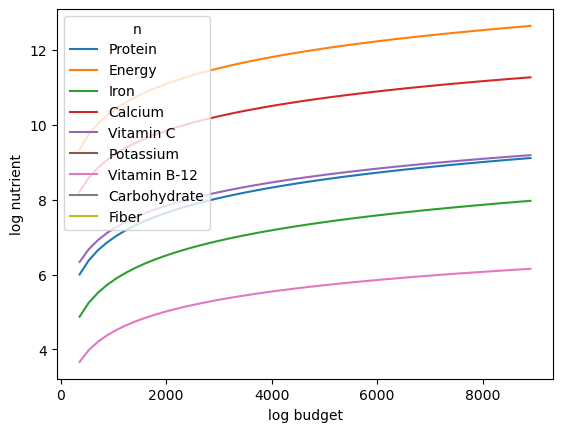

In [60]:
# Generate a range of household budgets from 1/5 to 5 times the reference budget (xref)
# This simulates very low-income to high-income households
X = np.linspace(xref / 5, xref * 5, 50)

# Define the nutrients to track in the plot
UseNutrients = ['Protein', 'Energy', 'Iron', 'Calcium', 'Vitamin C',
                'Potassium', 'Vitamin B-12', 'Carbohydrate', 'Fiber']

# For each budget level, compute log nutrient intake and collect results into a DataFrame
# This creates a wide DataFrame with nutrients as columns and budgets as the index
df = pd.concat(
    {myx: np.log(nutrient_demand(myx, pbar))[UseNutrients] for myx in X},
    axis=1
).T

# Plot the log nutrient intake across budgets
ax = df.plot()

# Label the X-axis as the log of household budget
ax.set_xlabel('log budget')

# Label the Y-axis as log nutrient intake
ax.set_ylabel('log nutrient')

### Price Elasticity of Nutrient Intake for Specific Foods

In [61]:
def plot_log_nutrient_vs_price(good):
    """
    Plots log nutrient demand versus price (log-log plot) for all nutrients in UseNutrients 
    while varying the price of a single good.

    Parameters:
    good (str): The food item whose price will be varied to observe effects on nutrient intake.
    """

    # Generate a range of price multipliers for the selected good (from 0.01x to 10x)
    scale = np.geomspace(0.01, 10, 50)

    # For each scaled price, compute the log of predicted nutrient intake
    # using the nutrient_demand function with a fixed budget (xref / 2)
    ndf = pd.DataFrame({
        s: np.log(nutrient_demand(xref / 2, my_prices(good, pbar[good] * s)))[UseNutrients]
        for s in scale
    }).T

    # Plot the resulting log nutrient intake vs. log price
    ax = ndf.plot()
    ax.set_xlabel('log price')      # X-axis: log of the price for the selected good
    ax.set_ylabel('log nutrient')   # Y-axis: log of nutrient intake
    ax.set_title(f'Log Nutrient Demand vs. Price for {good}')  # Title includes the food name

    plt.show()

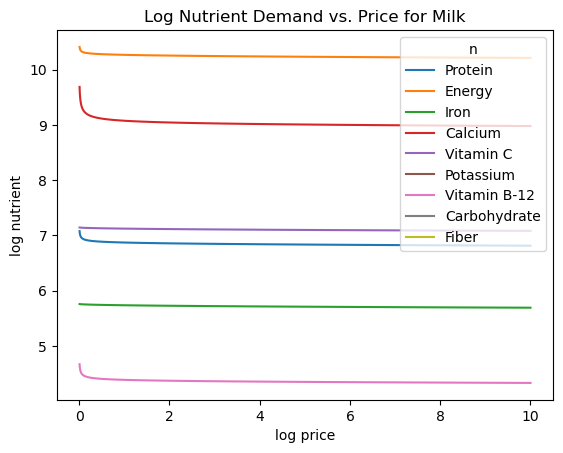

In [62]:
plot_log_nutrient_vs_price('Milk')

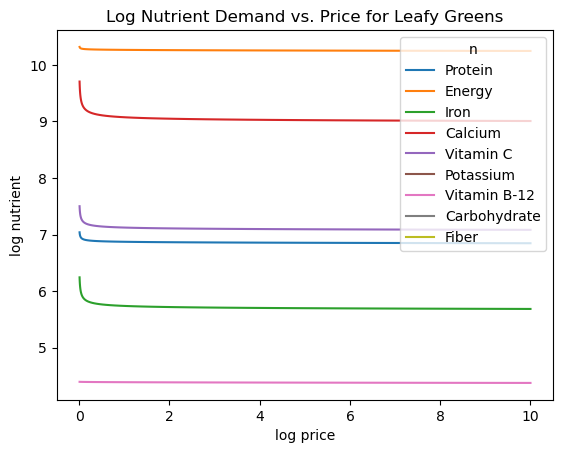

In [63]:
plot_log_nutrient_vs_price('Leafy Greens')

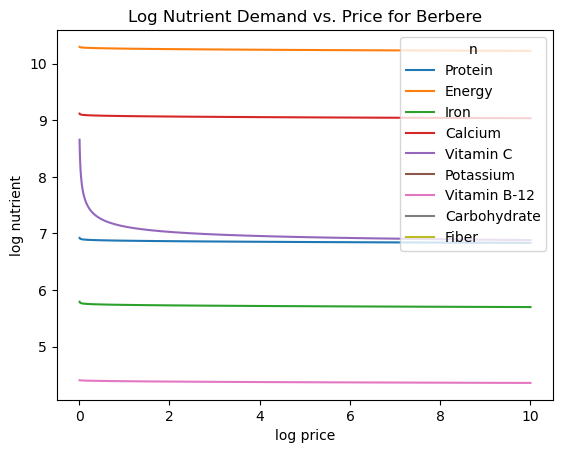

In [64]:
plot_log_nutrient_vs_price('Berbere')

### Nutritional Adequacy of Food Demands for Households

Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:

In [65]:
# In first round, averaged over households and villages
dbar = r.d[rdi.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:

In [66]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi@dbar

hh_rdi

n
Energy           7629.418935
Protein           171.352093
Fiber             106.811865
Folate           1427.377082
Calcium          4482.446160
Carbohydrate      554.995937
Iron               47.710687
Magnesium        1227.683868
Niacin             54.196668
Phosphorus       3346.921983
Potassium       18678.545307
Riboflavin          4.257883
Thiamin             4.131288
Vitamin A        2836.428281
Vitamin B-12        8.564262
Vitamin B-6         4.700223
Vitamin C         261.073751
Vitamin E          53.273872
Vitamin K         343.995327
Zinc               34.263714
dtype: float64

Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.

In [67]:
def nutrient_adequacy_ratio(x, p, d, rdi=rdi, days=7):
    """
    Computes the nutrient adequacy ratio (NAR) for a household given its budget, prices, and demographics.

    Parameters:
    - x (float): Total household food budget (e.g., in birr per week)
    - p (Series): Price vector for all goods
    - d (Series): Household demographic composition (e.g., average number in each group)
    - rdi (DataFrame): Recommended Dietary Intake table (nutrients × demographic groups)
    - days (int): Time period over which adequacy is measured (default: 7 days)

    Returns:
    - Series: Nutrient adequacy ratio for each nutrient (intake / requirement)
    """

    # Step 1: Compute total household nutrient requirements
    # Replace any blank values in RDI table with 0, then multiply by demographic weights and time period
    hh_rdi = rdi.replace('', 0) @ d * days

    # Step 2: Compute nutrient intake for given budget and prices using the demand system
    # Then divide by required intake to get adequacy ratio
    return nutrient_demand(x, p) / hh_rdi

### Log Nutrient Adequacy Ratios vs. Household Budget
In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.

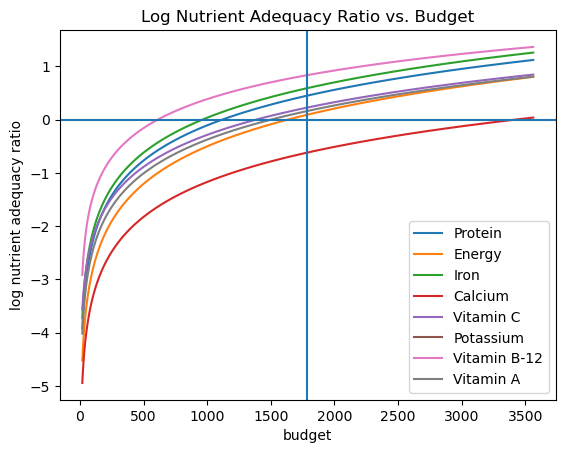

In [68]:
# Generate a range of hypothetical household budgets (from 1% to 200% of xref)
# xref is typically the median food budget
X = np.geomspace(0.01 * xref, 2 * xref, 100)

# List of nutrients to evaluate
UseNutrients = ['Protein', 'Energy', 'Iron', 'Calcium', 'Vitamin C',
                'Potassium', 'Vitamin B-12', 'Vitamin A']

# For each budget level in X, compute log nutrient adequacy ratio
# Returns a DataFrame with nutrients as columns and budgets as rows
df = pd.DataFrame({
    x: np.log(nutrient_adequacy_ratio(x, pbar, dbar))[UseNutrients]
    for x in X
}).T

# Plot log nutrient adequacy ratio curves
df.plot()

# Add legend to indicate which line corresponds to which nutrient
plt.legend(UseNutrients)

# Label the x-axis as budget
plt.xlabel('budget')

# Label the y-axis as log adequacy ratio (log of intake / requirement)
plt.ylabel('log nutrient adequacy ratio')

# Add horizontal line at 0 = adequate intake (intake = requirement)
plt.axhline(0)

# Add vertical line at xref = median budget
plt.axvline(xref)

# Add a descriptive title to the graph
plt.title("Log Nutrient Adequacy Ratio vs. Budget")

# Show the plot
plt.show()

### Nutrient Adequacy Sensitivity to Price Changes (Good-Specific)
As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:

In [69]:
def plot_nutrient_price_curve(good, nutrient):
    """
    Plots the relationship between price and log nutrient adequacy ratio for a given nutrient and good.
    
    This shows how changing the price of one good (holding others constant)
    affects household-level nutrient adequacy under a fixed budget.

    Parameters:
    - good (str): The food item whose price will be varied.
    - nutrient (str): The specific nutrient whose adequacy will be plotted.
    """

    # Create a range of price multipliers from 0.01x to 2x the base price
    scale = np.geomspace(0.01, 2, 50)

    prices = []       # Stores adjusted prices
    log_ratios = []   # Stores log nutrient adequacy ratios

    for s in scale:
        price = s * pbar[good]  # Scaled price of the selected good
        try:
            # Compute nutrient adequacy ratio using a fixed budget (xref / 4)
            nar = nutrient_adequacy_ratio(xref / 4, my_prices(good, price), dbar)

            # Take log of the adequacy ratio for the selected nutrient
            log_ratio = np.log(nar[nutrient])

            # Save results
            prices.append(price)
            log_ratios.append(log_ratio)

        except Exception as e:
            # Skip failed iterations (e.g., division by 0 or missing data)
            continue

    # Create a DataFrame of price vs. log adequacy for plotting
    ndf = pd.DataFrame({
        'Price': prices,
        'log_nutrient_adequacy_ratio': log_ratios
    })

    # Plot the log adequacy ratio (X-axis) vs. price (Y-axis)
    fig, ax = plt.subplots()
    ax.plot(ndf['log_nutrient_adequacy_ratio'], ndf['Price'])

    # Add horizontal line at base price and vertical line at adequacy threshold (log ratio = 0)
    ax.axhline(pbar[good], color='grey', linestyle='--', linewidth=1)
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)

    # Label axes
    ax.set_ylabel('Price')
    ax.set_xlabel('log nutrient adequacy ratio')

    # Title includes both the nutrient and good
    ax.set_title(f'Nutrient Adequacy of {nutrient} vs. Price for {good}')

    plt.show()

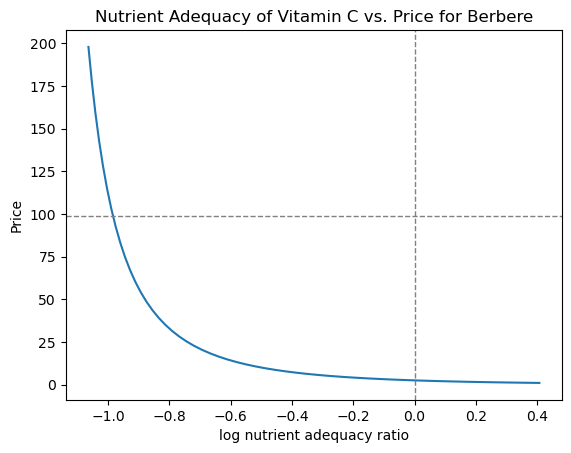

In [70]:
plot_nutrient_price_curve('Berbere', 'Vitamin C')

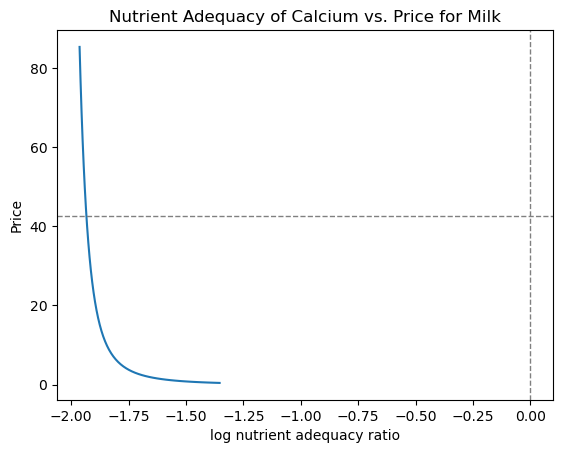

In [71]:
plot_nutrient_price_curve('Milk', 'Calcium')

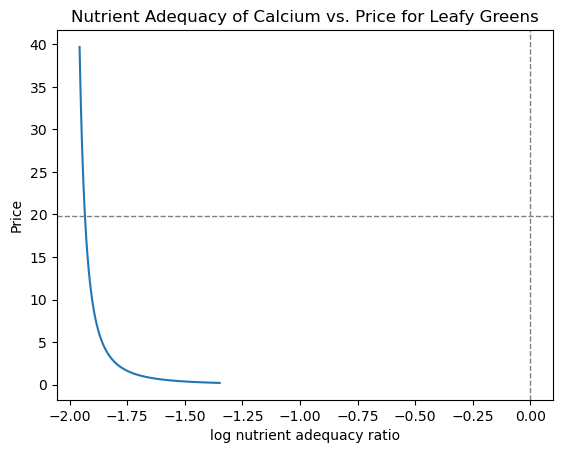

In [72]:
plot_nutrient_price_curve('Leafy Greens', 'Calcium')

# **Basic Visualizations:** Hicksian & Marshallion Demand, Welfare Measures, Deadweight Loss

#### Marshallian vs. Hicksian Demand Curves

Let&rsquo;s look at Marshallian & Hicksian demands&#x2014;one way of thinking
about the Hicksian (compensated) curves is that they  eliminate the
income effect associated with changing prices.

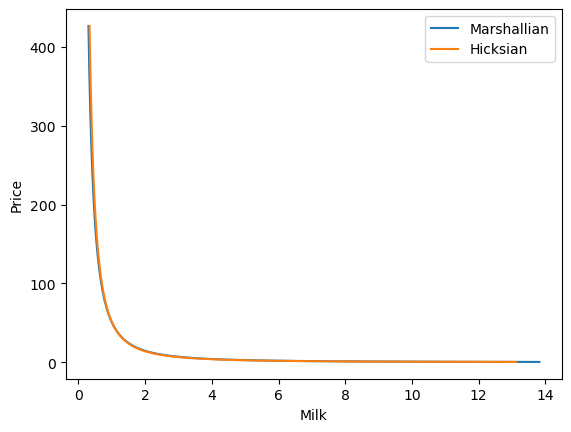

In [74]:
x0 = xbar.median()
# Define the good we're analyzing (in this case, Milk)
my_j = 'Milk'  # Interesting Ugandan staple

# Generate a range of prices for 'Milk', from 0.01× to 10× the baseline price
P = np.geomspace(0.01, 10, 50) * pbar[my_j]

# Compute the indirect utility level (U0) for the median household (with budget x0 and base prices)
# This utility will be used for the Hicksian (compensated) demand curve
U0 = r.indirect_utility(x0, pbar)

# === Plot Marshallian (uncompensated) demand curve ===
# For each price, compute the quantity of Milk demanded by a household with fixed budget x0
# Reflects both substitution and income effects
plt.plot(
    [r.demands(x0, my_prices(my_j, p0))[my_j] for p0 in P],  # X-axis: quantity
    P,                                                       # Y-axis: price
)

# === Plot Hicksian (compensated) demand curve ===
# For each price, compute the quantity of Milk demanded while holding utility constant (U0)
# Reflects only the substitution effect
plt.plot(
    [r.demands(U0, my_prices(my_j, p0), type="Hicksian")[my_j] for p0 in P],
    P
)

# Label the y-axis as price of the good
plt.ylabel('Price')

# Label the x-axis as quantity of the good demanded
plt.xlabel(my_j)

# Add a legend to distinguish Marshallian vs. Hicksian demand curves
plt.legend(("Marshallian", "Hicksian"))

#### Welfare measures

In [75]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

#### Price Changes, Revenue, and Compensating Variation

Examine effects of price changes on revenue (if price change due to a
tax or subsidy) and compensating variation.

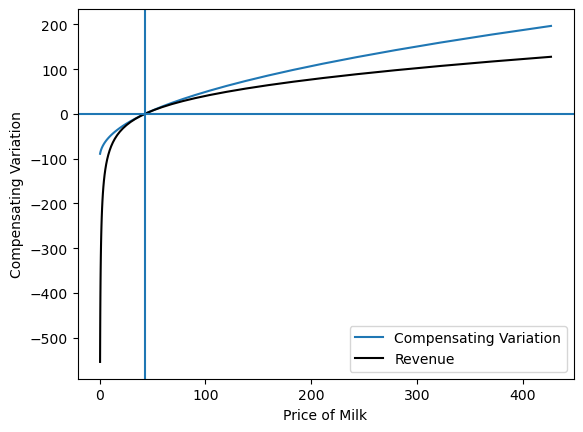

In [76]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(my_j,p0),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])

#### Deadweight Loss

Differences between revenue and compensating variation is deadweight-loss:

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")

In [ ]:
ax = r.get_w().plot.hist(bins=100,density=True)
r.get_w().plot.kde(ax=ax)

# **Policy Approaches**
## **[A] Policy 1:** Cash Transfer and Nutritional Systems
Contains the adjusted expenditure after a given conditional cash transfer is applied

In [ ]:
def get_adjusted_reference_budget(cct_amount):
    """
    Returns adjusted reference budget based on median household budget + CCT.
    """
    return xref + cct_amount

In [ ]:
xref_cct = get_adjusted_reference_budget(500)
xref_cct

In [ ]:
def plot_top_engel_curves_with_cct(cct_amount=0, r_model=r):
    """
    Plots Engel curves for top 10 predicted goods using a CCT-adjusted budget if specified.

    Parameters:
    - cct_amount (float): Cash transfer amount in birr. If 0, reflects pre-CCT Engel curves.
    - r_model (Regression): Fitted regression model (default: global `r`)
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Step 1: Get predicted expenditures
    xhat = r_model.predicted_expenditures().unstack('j').fillna(0)

    # Step 2: Compute reference budget
    xref_adj = xhat.sum(axis=1).median() + cct_amount

    # Step 3: Identify top 10 goods
    top_goods = xhat.sum().sort_values(ascending=False).head(10).index.tolist()

    # Step 4: Prepare Engel curves
    scale = np.geomspace(0.01, 10, 50)
    fig, ax = plt.subplots(figsize=(10, 6))

    for good in top_goods:
        shares = []
        for s in scale:
            exp = r_model.expenditures(s * xref_adj, pbar)
            shares.append(exp.get(good, np.nan) / (s * xref_adj))
        ax.plot(np.log(scale * xref_adj), shares, label=good)

    # Step 5: Set dynamic title
    if cct_amount == 0:
        title = 'Engel Curves: Top 10 Most Predicted Goods (Pre-CCT)'
    else:
        title = f'Engel Curves: Top 10 Most Predicted Goods (Post-CCT: +{cct_amount:.0f} birr)'

    # Finalize plot
    ax.set_xlabel(f'log Budget (relative to base of {xref_adj:.0f})')
    ax.set_ylabel('Expenditure Share')
    ax.set_title(title)
    ax.legend(title='Good', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_top_engel_curves_with_cct(0)
plot_top_engel_curves_with_cct(500)

In [ ]:
def plot_demand_curve_bottom50_simulated_cct(food_item, r_model, cct_amount=0, price_points=20):
    """
    Plots Hicksian-style demand curves for a specific food item using a fixed regression model.
    It simulates how demand changes across price levels for the bottom 50% of households,
    optionally adjusting budgets by a specified Conditional Cash Transfer (CCT) amount.

    Parameters:
    - food_item (str): Name of the good to analyze (e.g., 'Milk')
    - r_model (Regression): A pre-fitted regression object used to simulate demand
    - cct_amount (float): The size of the CCT in birr to simulate (default = 0 for pre-CCT)
    - price_points (int): Number of price levels to simulate (default = 20)
    """

    # === Step 1: Get predicted expenditures from the model and compute total budget per household
    xhat = r_model.predicted_expenditures().unstack('j').fillna(0)  # wide format (rows = households, cols = goods)
    total_budget = xhat.sum(axis=1)  # total food budget per household

    # === Step 2: Focus on bottom 50% of households by budget
    bottom_50 = total_budget[total_budget <= total_budget.quantile(0.5)]

    # Compute the 25th and 50th percentile budgets, and add CCT amount if applicable
    q25 = bottom_50.quantile(0.25) + cct_amount
    q50 = bottom_50.quantile(0.50) + cct_amount

    # === Step 3: Generate price range for simulation, from 50% to 200% of base price
    base_price = pbar[food_item]  # reference price from average prices
    price_scale = np.linspace(0.5, 2.0, price_points)

    # === Step 4: Simulate quantity demanded for each price level at a given budget
    def simulate_demand(budget):
        return [
            r_model.demands(budget, my_prices(food_item, base_price * s)).get(food_item, np.nan)
            for s in price_scale
        ]

    # Get quantity demanded curves at both 25th and 50th percentile budgets
    q25_curve = simulate_demand(q25)
    q50_curve = simulate_demand(q50)

    # === Step 5: Plot the demand curves
    plt.figure()
    plt.plot(q50_curve, price_scale, label='50th Percentile Budget')
    plt.plot(q25_curve, price_scale, label='25th Percentile Budget')

    # Set axis labels
    plt.xlabel(f'Quantity of {food_item} Demanded')
    plt.ylabel('Price (relative to base)')

    # Title reflects whether CCT is applied
    context = "Post-CCT" if cct_amount > 0 else "Pre-CCT"
    plt.title(f'Demand for {food_item} ({context}, Bottom 50%)')

    # Add legend and display
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
plot_demand_curve_bottom50_simulated_cct('Milk', r, cct_amount=0)        # Pre-CCT
plot_demand_curve_bottom50_simulated_cct('Milk', r, cct_amount=500)      # Post-CCT

In [ ]:
plot_demand_curve_bottom50_simulated_cct('Leafy Greens', r, cct_amount=0)        # Pre-CCT
plot_demand_curve_bottom50_simulated_cct('Leafy Greens', r, cct_amount=500)      # Post-CCT

In [ ]:
def plot_nutrient_price_curve_fixed_model(food_item, nutrient, cct_amount=0):
    """
    Plots the relationship between the price of a specific food and the log nutrient adequacy ratio
    for a selected nutrient, simulating a fixed household budget with optional CCT adjustment.

    Parameters:
    - food_item (str): The food item whose price is varied (e.g., 'Milk')
    - nutrient (str): The nutrient to track (e.g., 'Calcium')
    - cct_amount (float): Optional amount of conditional cash transfer added to household budget
    """

    import numpy as np
    import matplotlib.pyplot as plt

    # === Step 1: Define base price and price range to simulate
    base_price = pbar[food_item]
    scale = np.geomspace(0.01, 2.0, 50)  # simulate price from 1% to 200% of base
    prices = [base_price * s for s in scale]

    # === Step 2: Fixed household characteristics and adjusted budget
    budget = (xref / 2) + cct_amount  # simulate low-income household + optional CCT
    d = dbar  # demographic weights (e.g., avg household composition)

    # === Step 3: Compute log nutrient adequacy ratio at each price
    log_ratios = []
    for p in prices:
        try:
            # Adjust only the price of the selected good
            p_vec = my_prices(food_item, p)

            # Get predicted quantities using demand system
            q = r.demands(budget, p_vec)

            # Align quantities with FCT nutrient matrix
            fct_aligned, q_aligned = fct.align(q, axis=0, join='inner')
            nutrient_intake = fct_aligned.T @ q_aligned

            # Compute household RDI (over 7 days)
            requirement = (rdi.replace('', 0) @ d) * 7

            # Log nutrient adequacy ratio = log(intake / requirement)
            log_ratio = np.log(nutrient_intake[nutrient] / requirement[nutrient])
            log_ratios.append(log_ratio)

        except Exception:
            log_ratios.append(np.nan)

    # === Step 4: Plot
    plt.figure(figsize=(8, 6))
    plt.plot(log_ratios, prices)
    plt.axhline(base_price, color='gray', linestyle='--', linewidth=1, label='Base Price')
    plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Adequacy Threshold')

    # Labels and title
    plt.xlabel('log Nutrient Adequacy Ratio')
    plt.ylabel('Price')
    cct_label = f'Post-CCT (+{cct_amount:.0f} birr)' if cct_amount > 0 else 'Pre-CCT'
    plt.title(f'Nutrient Adequacy of {nutrient} vs. Price of {food_item} ({cct_label})')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Pre-CCT
plot_nutrient_price_curve_fixed_model('Leafy Greens', 'Calcium', cct_amount=0)

# Post-CCT with 500 birr transfer
plot_nutrient_price_curve_fixed_model('Leafy Greens', 'Calcium', cct_amount=500)


In [ ]:
def plot_nutrient_adequacy_by_adjusted_budget(UseNutrients, cct_amount=0, days=7, r_model=r):
    """
    Plots log nutrient adequacy ratios for specified nutrients across a range of household budgets.
    Simulates the effect of a conditional cash transfer (CCT) by adjusting the budget upward.

    Parameters:
    - UseNutrients (list of str): Nutrients to include in the plot
    - cct_amount (float): Optional CCT amount added to household budgets (default: 0)
    - days (int): Number of days over which to compute adequacy (default: 7)
    - r_model (Regression): Fitted demand regression model (default: r)
    """

    # === Step 1: Compute reference budget from predicted expenditures
    xhat = r_model.predicted_expenditures()
    xbar = xhat.groupby(['i', 't', 'm']).sum()
    xref = xbar.quantile(0.5) + cct_amount  # adjust reference budget if CCT applied

    # === Step 2: Budget range from 1% to 200% of adjusted reference budget
    X = np.geomspace(0.01 * xref, 2 * xref, 100)

    # === Step 3: Define nutrient adequacy ratio function
    def nutrient_adequacy_ratio(x, p, d, rdi=rdi, days=7):
        hh_rdi = rdi.replace('', 0) @ d * days
        return nutrient_demand(x, p) / hh_rdi

    # === Step 4: Simulate adequacy ratios across budget levels
    result_df = pd.DataFrame({
        x: np.log(nutrient_adequacy_ratio(x, pbar, dbar))[UseNutrients]
        for x in X
    }).T
    result_df.index.name = 'Budget'

    # === Step 5: Plot results
    ax = result_df.plot(figsize=(10, 6))
    ax.axhline(0, color='red', linestyle='--', label='Adequacy Threshold')
    ax.axvline(xref, label='Reference Budget')

    # Title reflects whether CCT is applied
    context = f"Post-CCT ({cct_amount})" if cct_amount > 0 else "Pre-CCT"
    ax.set_title(f'Nutrient Adequacy vs. Budget ({context})')
    ax.set_xlabel(f'Household Budget (median = {int(xref):,})')
    ax.set_ylabel('log Nutrient Adequacy Ratio')
    ax.legend(title='Nutrient', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_nutrient_adequacy_by_adjusted_budget(
    UseNutrients,
    cct_amount=0,
    days=7
)

plot_nutrient_adequacy_by_adjusted_budget(
    UseNutrients,
    cct_amount=500,
    days=7
)
plot_nutrient_adequacy_by_adjusted_budget(
    UseNutrients,
    cct_amount=1000,
    days=7
)

## **[A] Policy 3:** Biofortification

In [ ]:
def simulate_biofortification(fct, food, nutrient_increases):
    """
    Simulates biofortification by increasing the nutrient content of a specified food.

    Parameters:
    - fct (DataFrame): Food Composition Table (indexed by food items, columns are nutrients)
    - food (str): Name of the food to biofortify (must be an index in fct)
    - nutrient_increases (dict): Dictionary of nutrient names and relative increase factors (e.g., {"Iron": 1.5})

    Returns:
    - fct_modified (DataFrame): A new FCT DataFrame with simulated biofortification applied
    """
    fct_modified = fct.copy()

    for nutrient, multiplier in nutrient_increases.items():
        if food in fct_modified.index and nutrient in fct_modified.columns:
            fct_modified.loc[food, nutrient] *= multiplier
        else:
            print(f"Warning: {food} or {nutrient} not found in FCT")

    return fct_modified

In [262]:
# Increase Iron by 60% and Vitamin A by 100% in maize
fct_biofortified = simulate_biofortification(
    fct,
    food='Milk',
    nutrient_increases={'Calcium': 1.0, 'Vitamin A': 1.0}
)
fct_biofortified = simulate_biofortification(
    fct_biofortified,
    food='Leafy Greens',
    nutrient_increases={'Calcium': 1.0, 'Vitamin A': 1.0}
)
fct_biofortified = simulate_biofortification(
    fct_biofortified,
    food='Injera',
    nutrient_increases={'Calcium': 1.0}
)
fct_biofortified = simulate_biofortification(
    fct_biofortified,
    food='Maize',
    nutrient_increases={'Vitamin A': 1000.0}
)

In [217]:
def plot_log_nutrient_vs_price_with_fct(good, fct_input, nutrients=UseNutrients, label=''):
    """
    Plots log nutrient demand vs. price for a given food using a custom FCT (e.g., biofortified).
    
    Parameters:
    - good (str): Food item to vary in price
    - fct_input (DataFrame): Food Composition Table to use (can be biofortified version)
    - nutrients (list): Nutrients to track
    - label (str): Optional label for the plot title (e.g., "Biofortified")
    """
    scale = np.geomspace(0.01, 10, 50)

    def nutrient_demand_custom(x, p, fct_df):
        c = r.demands(x, p)
        fct0, c0 = fct_df.align(c, axis=0, join='inner')
        N = fct0.T @ c0
        return N.loc[~N.index.duplicated()]

    ndf = pd.DataFrame({
        s: np.log(nutrient_demand_custom(xref / 2, my_prices(good, pbar[good] * s), fct_input))[nutrients]
        for s in scale
    }).T

    ax = ndf.plot(figsize=(10, 5))
    ax.set_xlabel('log price')
    ax.set_ylabel('log nutrient')
    ax.set_title(f'Log Nutrient Demand vs. Price for {good} {label}')
    plt.tight_layout()
    plt.show()

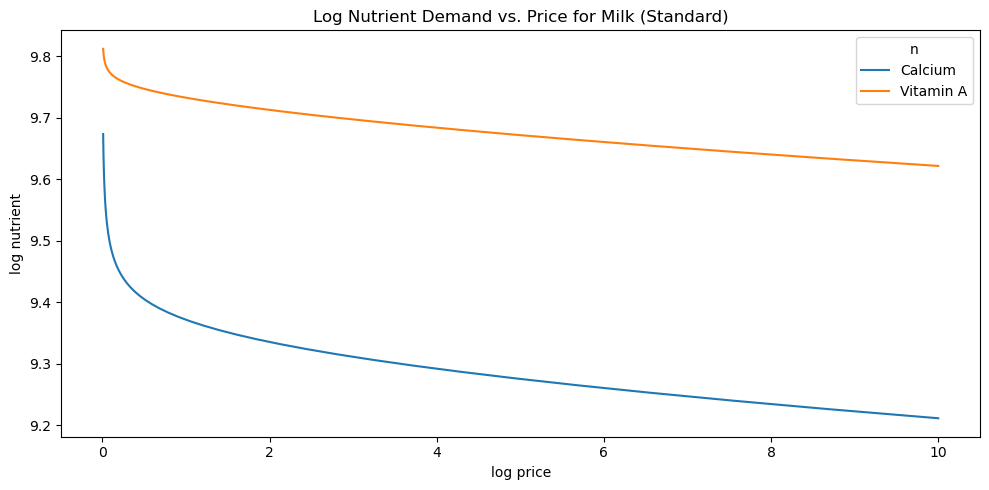

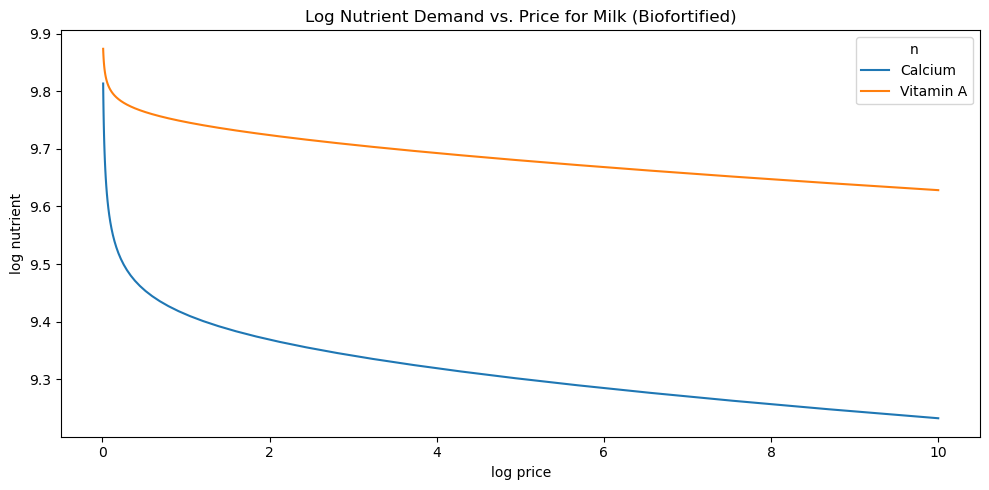

In [218]:
plot_log_nutrient_vs_price_with_fct('Milk', fct, nutrients=['Calcium', 'Vitamin A'], label='(Standard)')
plot_log_nutrient_vs_price_with_fct('Milk', fct_biofortified, nutrients=['Calcium', 'Vitamin A'], label='(Biofortified)')

In [226]:
def plot_nutrient_adequacy_by_budget_custom_fct(
    fct_input, UseNutrients, cct_amount=0, days=7, r_model=r
):
    """
    Plots log nutrient adequacy ratios for a list of nutrients across household budgets,
    using a custom FCT (e.g., biofortified) and optional CCT policy.

    Parameters:
    - fct_input (DataFrame): Custom Food Composition Table
    - UseNutrients (list of str): Nutrients to plot
    - cct_amount (float): Cash transfer added to each household budget
    - days (int): Nutrient calculation period
    - r_model (Regression): Regression model for predicting demand
    """
    # Step 1: Predicted expenditures and adjusted reference budget
    xhat = r_model.predicted_expenditures()
    xbar = xhat.groupby(['i', 't', 'm']).sum()
    xref = xbar.quantile(0.5) + cct_amount  # Adjust for CCT

    # Step 2: Budget sweep
    X = np.geomspace(0.01 * xref, 2 * xref, 100)

    # Step 3: Demand from custom FCT
    def nutrient_demand_custom(x, p, fct_df):
        q = r_model.demands(x, p)
        fct0, q0 = fct_df.align(q, axis=0, join='inner')
        N = fct0.T @ q0
        return N.loc[~N.index.duplicated()]

    # Step 4: Compute nutrient adequacy ratio
    hh_rdi = rdi.replace('', 0) @ dbar * days
    def adequacy(x): return nutrient_demand_custom(x, pbar, fct_input) / hh_rdi

    # Step 5: Simulate and collect results
    result_df = pd.DataFrame({
        x: np.log(adequacy(x))[UseNutrients]
        for x in X
    }).T
    result_df.index.name = 'Budget'

    # Step 6: Plot in style matching your image
    ax = result_df.plot(figsize=(10, 6))
    ax.axhline(0, color='red', linestyle='--', label='Adequacy Threshold')
    ax.axvline(xref, color='blue', label='Reference Budget')

    median_fmt = f"{int(xref):,}"
    context = f"Post-CCT ({cct_amount})" if cct_amount > 0 else "Pre-CCT"
    ax.set_title(f'Nutrient Adequacy vs. Budget ({context})')
    ax.set_xlabel(f'Household Budget (median = {median_fmt})')
    ax.set_ylabel('log Nutrient Adequacy Ratio')
    ax.legend(title='Nutrient', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.82E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


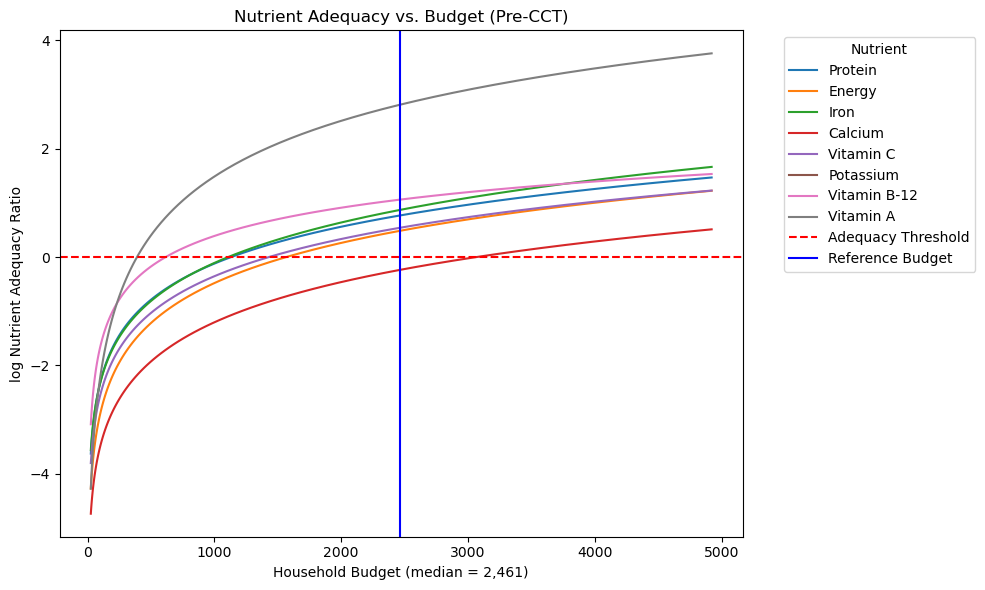

In [263]:
plot_nutrient_adequacy_by_budget_custom_fct(
    fct_input=fct_biofortified,
    UseNutrients=UseNutrients,
    cct_amount=0
)

## **Additional Visualizations**

In [178]:
def plot_nutrients_for_food(food_item, fct_df):
    """
    Plots a bar chart of nutrient values for a specific food item.

    Parameters:
    - food_item (str): Name of the food (must match an index in fct_df)
    - fct_df (pd.DataFrame): Food Composition Table with food items as index and nutrients as columns
    """
    if food_item not in fct_df.index:
        print(f"'{food_item}' not found in the food composition table.")
        return

    # Extract nutrient data for the selected food
    nutrient_data = fct_df.loc[food_item]

    # Drop missing or zero values for clarity
    nutrient_data = nutrient_data.dropna()
    nutrient_data = nutrient_data[nutrient_data != 0]

    # Plot
    plt.figure()
    nutrient_data.plot(kind='bar', color='skyblue')
    plt.title(f'Nutrient Composition of {food_item}')
    plt.ylabel('Amount per 100g')
    plt.xlabel('Nutrient')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

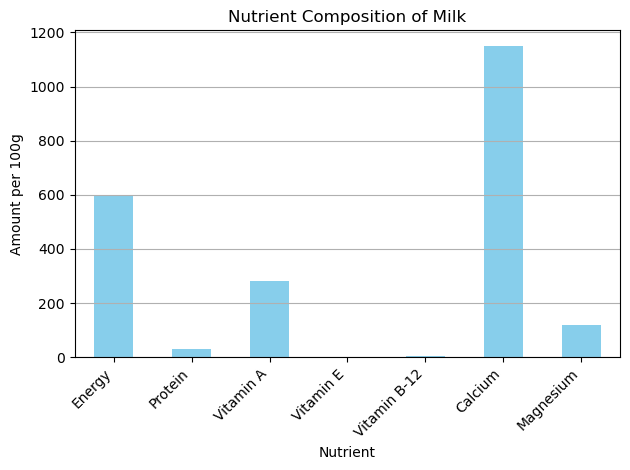

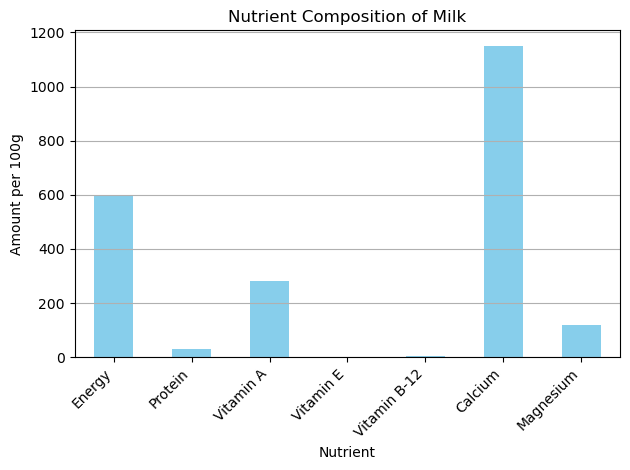

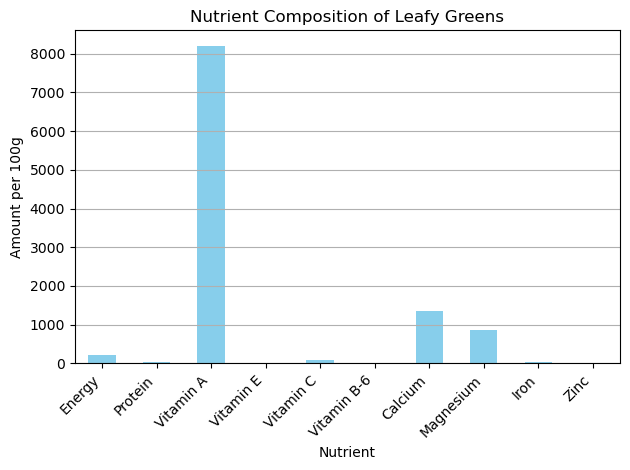

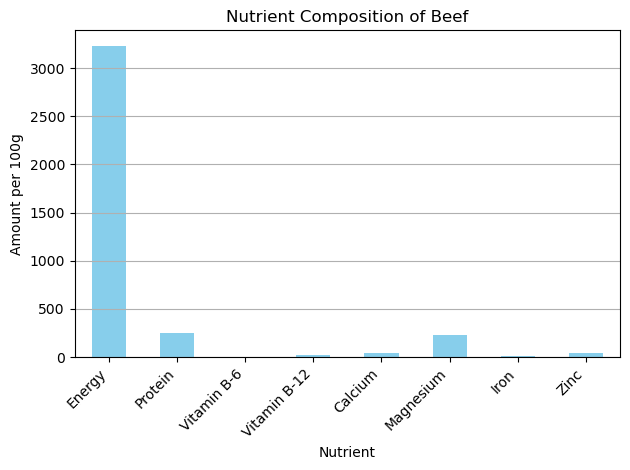

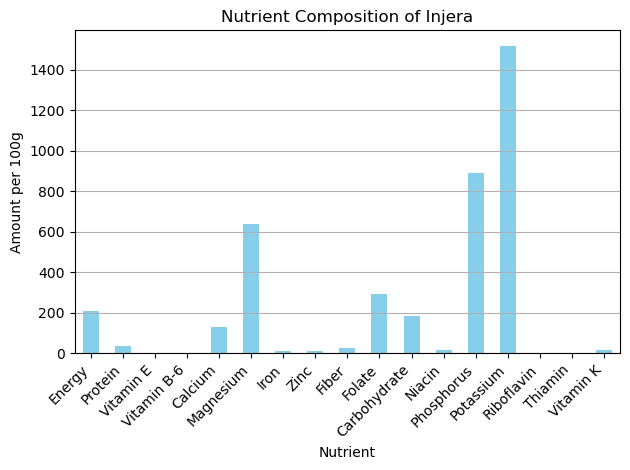

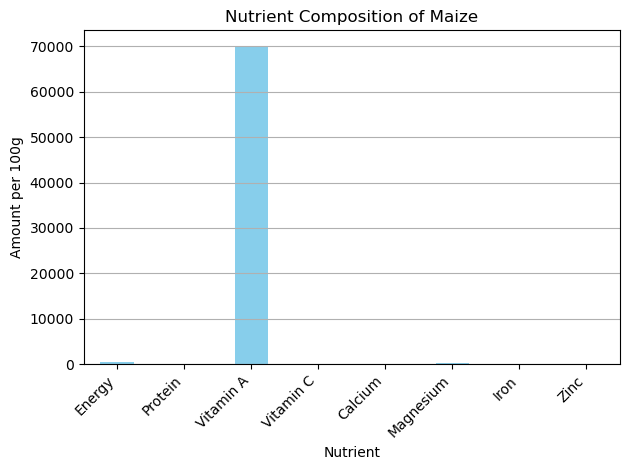

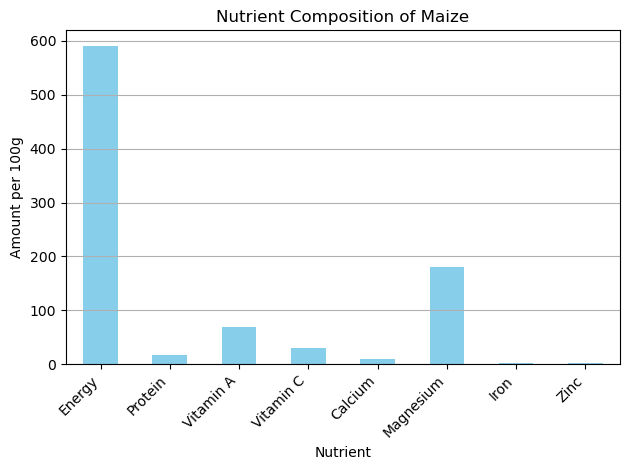

In [264]:
plot_nutrients_for_food('Milk', fct)
plot_nutrients_for_food('Milk', fct_biofortified)
plot_nutrients_for_food('Leafy Greens', fct)
plot_nutrients_for_food('Beef', fct)
plot_nutrients_for_food('Injera', fct)
plot_nutrients_for_food('Maize', fct_biofortified)
plot_nutrients_for_food('Maize', fct)

In [198]:

def plot_average_prices(goods, prices_df):
    """
    Plots a bar chart of average prices across regions for a list of goods.

    Parameters:
    - goods (list of str): List of food item names to include in the plot
    - prices_df (pd.DataFrame): DataFrame containing columns 'j' (item name) and 'Price'
    """
    # Filter for the specified goods
    filtered = prices_df[prices_df['j'].isin(goods)]

    # Compute average price per good
    avg_prices = filtered.groupby('j')['Price'].mean()

    # Plot
    plt.figure(figsize=(10, 5))
    avg_prices.plot(kind='bar', color='salmon')
    plt.title('Average Price of Goods Across Regions')
    plt.ylabel('Average Price (birr/kg)')
    plt.xlabel('Food Item')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

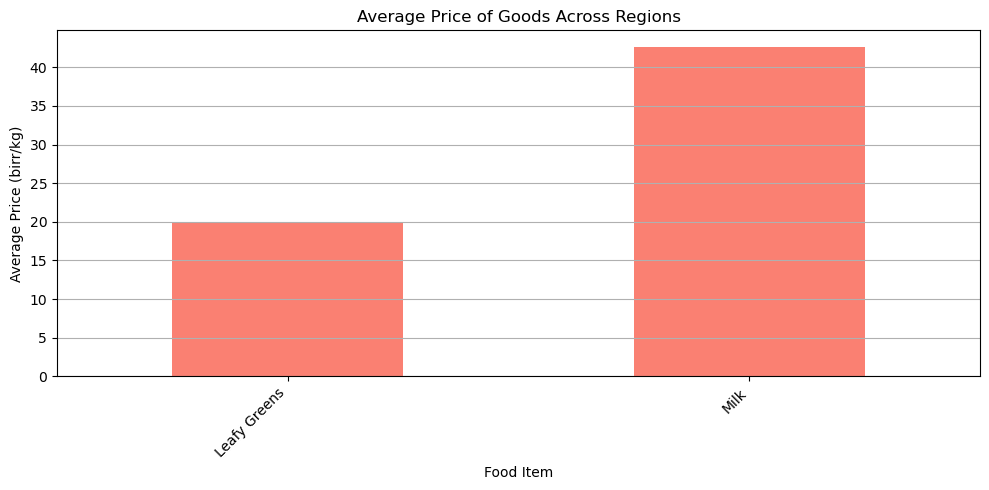

In [199]:
plot_average_prices(['Milk', 'Leafy Greens'], prices)